# **nanoRF: A simplified nano pytorch version of a rectified flow** 
Paper: https://arxiv.org/abs/2403.03206. Borrowed some code from https://github.com/tinygrad/tinygrad/blob/master/examples/minrf.py

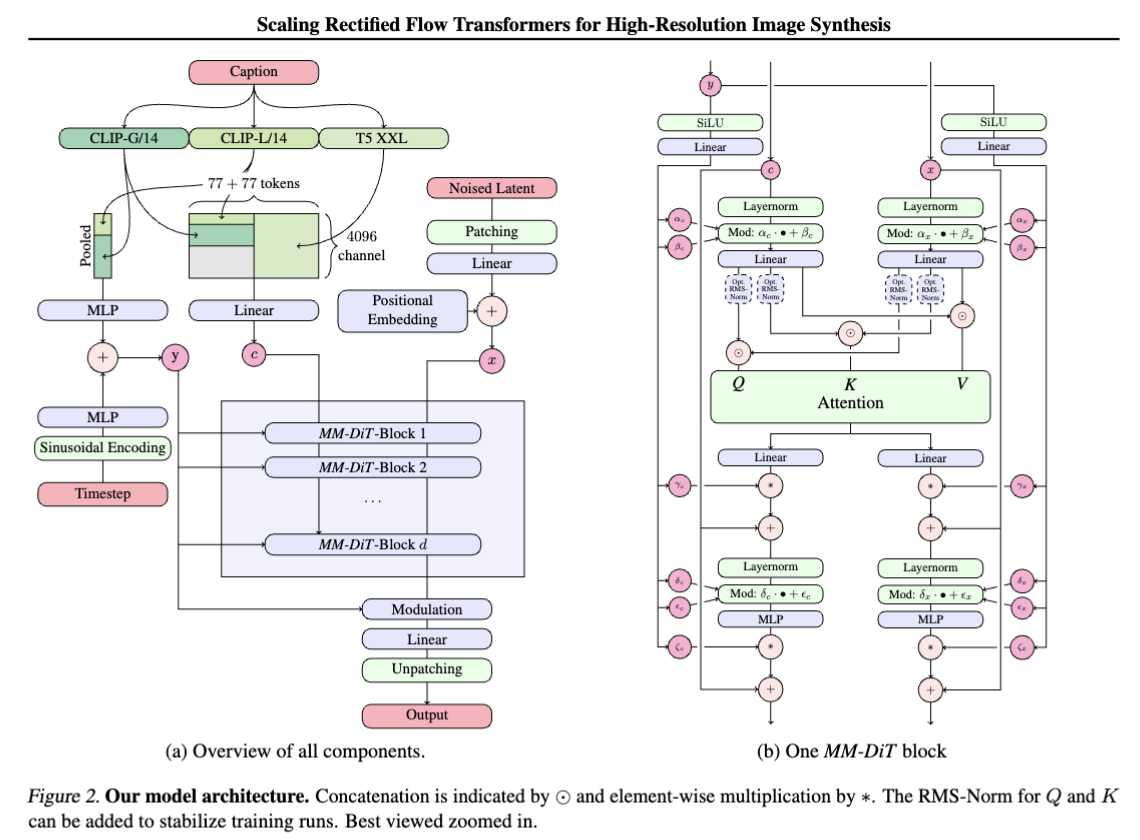

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import trange

# ==========================
# Helpers
# ==========================
def precompute_freqs_cis_torch(dim: int, end: int, theta: float = 10000.0, device: torch.device = None) -> torch.Tensor:
    """
    Precomputes frequencies for rotary embeddings.
    Args:
        dim (int): Dimension of the embeddings.
        end (int): The maximum sequence length.
        theta (float): Frequency scaling factor.
        device (torch.device): Device to store the tensor on.
    Returns:
        torch.Tensor: Precomputed frequencies.
    """
    if device is None:
        device = torch.device("cpu")
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2, device=device, dtype=torch.float32) / dim))
    t = torch.arange(end, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cos = torch.cos(freqs)
    freqs_sin = torch.sin(freqs)
    return torch.stack([freqs_cos, freqs_sin], dim=-1)

def apply_rotary_emb_torch(x: torch.Tensor, freqs_cis: torch.Tensor) -> torch.Tensor:
    """
    Applies rotary embeddings to the input tensor.
    Args:
        x (torch.Tensor): Input tensor of shape (B, T, C).
        freqs_cis (torch.Tensor): Precomputed frequencies of shape (T, 2).
    Returns:
        torch.Tensor: Tensor with rotary embeddings applied.
    """
    x_reshaped = x.float().reshape(*x.shape[:-1], -1, 2)
    freqs_cis = freqs_cis.unsqueeze(0).unsqueeze(2)
    x0 = x_reshaped[..., 0]
    x1 = x_reshaped[..., 1]
    f0 = freqs_cis[..., 0]
    f1 = freqs_cis[..., 1]
    y0 = x0 * f0 - x1 * f1
    y1 = x0 * f1 + x1 * f0
    y = torch.stack([y0, y1], dim=-1).flatten(start_dim=-2)
    return y.type_as(x)

def modulate(x:torch.Tensor, shift:torch.Tensor, scale:torch.Tensor) -> torch.Tensor:
    """
    Modulates the input tensor with shift and scale.
    Args:
        x (torch.Tensor): Input tensor.
        shift (torch.Tensor): Shift tensor.
        scale (torch.Tensor): Scale tensor.
    Returns:
        torch.Tensor: Modulated tensor.
    """
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

class TimestepEmbedder(nn.Module):
    """
    A simple MLP for timestep embedding.
    Args:
        hidden_size (int): Size of the hidden layer.
    Returns:
        torch.Tensor: Embedded timestep.
    """
    def __init__(self, hidden_size):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size)
        )
    def __call__(self, t:torch.Tensor):
        return self.mlp(t.reshape(-1, 1).float())

# ==========================
# DiT-LLaMA Model
# ==========================
class Attention(nn.Module):
    def __init__(self, dim, n_heads):
        super().__init__()
        assert dim % n_heads == 0, "dim must be divisible by n_heads"
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.scale = self.head_dim**-0.5
        self.wq = nn.Linear(dim, dim, bias=False)
        self.wk = nn.Linear(dim, dim, bias=False)
        self.wv = nn.Linear(dim, dim, bias=False)
        self.wo = nn.Linear(dim, dim, bias=False)

    def __call__(self, x: torch.Tensor, freqs_cis: torch.Tensor):
        bsz, seqlen, _ = x.shape
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)
        xq = xq.view(bsz, seqlen, self.n_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_heads, self.head_dim)
        xq = apply_rotary_emb_torch(xq, freqs_cis)
        xk = apply_rotary_emb_torch(xk, freqs_cis)
        xq = xq.transpose(1, 2)
        xk = xk.transpose(1, 2)
        xv = xv.transpose(1, 2)
        scores = torch.matmul(xq, xk.transpose(-2, -1)) * self.scale
        attn_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, xv)
        output = output.transpose(1, 2).contiguous().view(bsz, seqlen, -1)
        return self.wo(output)

# LLaMA-style FeedForward (SwiGLU)
class FeedForward(nn.Module):
    def __init__(self, dim: int, hidden_dim_multiplier: int = 4, multiple_of: int = 256):
        super().__init__()
        _ff_expanded_dim = dim * hidden_dim_multiplier
        true_hidden_dim = int(2 * _ff_expanded_dim / 3)
        true_hidden_dim = multiple_of * ((true_hidden_dim + multiple_of - 1) // multiple_of)
        self.w1 = nn.Linear(dim, true_hidden_dim, bias=False)
        self.w3 = nn.Linear(dim, true_hidden_dim, bias=False)
        self.w2 = nn.Linear(true_hidden_dim, dim, bias=False)
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return self.w2(F.silu(self.w1(x)) * self.w3(x))

class TransformerBlock(nn.Module):
    def __init__(self, dim, n_heads, norm_eps=1e-5):
        super().__init__()
        self.attention = Attention(dim, n_heads)
        self.feed_forward = FeedForward(dim, hidden_dim_multiplier=4)
        self.attention_norm = nn.LayerNorm(dim, eps=norm_eps)
        self.ffn_norm = nn.LayerNorm(dim, eps=norm_eps)
        self.adaLN_modulation = nn.Linear(dim, 6 * dim, bias=True)

    def __call__(self, x:torch.Tensor, freqs_cis:torch.Tensor, adaln_input:torch.Tensor):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = \
            self.adaLN_modulation(F.silu(adaln_input)).chunk(6, dim=1)
        h_attn = modulate(self.attention_norm(x), shift_msa, scale_msa)
        h_attn = self.attention(h_attn, freqs_cis)
        x = x + gate_msa.unsqueeze(1) * h_attn
        h_ffn = modulate(self.ffn_norm(x), shift_mlp, scale_mlp)
        h_ffn = self.feed_forward(h_ffn)
        x = x + gate_mlp.unsqueeze(1) * h_ffn
        return x.contiguous()

class FinalLayer(nn.Module):
    def __init__(self, dim, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(dim, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(dim, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Linear(dim, 2 * dim, bias=True)
        with torch.no_grad():
            self.linear.weight.zero_()
            self.linear.bias.zero_()
    def __call__(self, x:torch.Tensor, c:torch.Tensor):
        shift, scale = self.adaLN_modulation(F.silu(c)).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        return self.linear(x)

class DiT_Llama(nn.Module):
    def __init__(self, in_channels=1, dim=64, n_layers=6, n_heads=4, num_classes=10, patch_size=2,
                 img_size=32, max_seq_len=512, device: torch.device = None):
        super().__init__()
        self.patch_size = patch_size
        self.out_channels = in_channels
        self.num_classes = num_classes
        self.dim = dim
        self.n_heads = n_heads
        self.device = device if device is not None else torch.device("cpu")

        conv_out_channels = dim // 2
        gn_num_groups = 1
        if conv_out_channels > 0:
             gn_num_groups = 32 if (conv_out_channels >= 32 and conv_out_channels % 32 == 0) else 1
        else:
            conv_out_channels = 1 # at least 1 channel for Conv2d

        self.init_conv_seq = nn.Sequential(
            nn.Conv2d(in_channels, conv_out_channels, kernel_size=5, padding=2, stride=1), nn.SiLU(),
            nn.GroupNorm(gn_num_groups, conv_out_channels),
            nn.Conv2d(conv_out_channels, conv_out_channels, kernel_size=5, padding=2, stride=1), nn.SiLU(),
            nn.GroupNorm(gn_num_groups, conv_out_channels),
        )
        self.x_embedder = nn.Linear(self.patch_size * self.patch_size * conv_out_channels, dim, bias=True)
        self.t_embedder = TimestepEmbedder(dim)
        self.y_embedder = nn.Embedding(num_classes + 1, dim)
        self.final_layer = FinalLayer(dim, self.patch_size, self.out_channels)
        head_dim = dim // n_heads
        num_patches = (img_size // patch_size)**2
        actual_max_seq_len = max(num_patches, max_seq_len if max_seq_len is not None else 0)
        if actual_max_seq_len == 0: actual_max_seq_len = 256
        freqs_cis_data = precompute_freqs_cis_torch(head_dim, actual_max_seq_len, device=self.device)
        self.register_buffer("freqs_cis", freqs_cis_data)
        self.layers = nn.ModuleList([TransformerBlock(dim, n_heads) for _ in range(n_layers)])

    def unpatchify(self, x: torch.Tensor):
        B, N, _ = x.shape
        P = self.patch_size
        C_out = self.out_channels
        H_patches = W_patches = int(N**0.5)
        assert N == H_patches * W_patches, f"Number of patches {N} must allow integer square root."
        x = x.view(B, H_patches, W_patches, P, P, C_out)
        x = x.permute(0, 5, 1, 3, 2, 4)
        x = x.reshape(B, C_out, H_patches * P, W_patches * P)
        return x

    def patchify(self, x: torch.Tensor):
        B, C_in, H, W = x.shape
        P = self.patch_size
        assert H % P == 0 and W % P == 0, f"Image dimensions ({H},{W}) must be divisible by patch size {P}."
        num_patches_h = H // P
        num_patches_w = W // P
        x = x.view(B, C_in, num_patches_h, P, num_patches_w, P)
        x = x.permute(0, 2, 4, 1, 3, 5)
        x = x.flatten(start_dim=3)
        x = x.flatten(start_dim=1, end_dim=2)
        return x

    def __call__(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        x = self.init_conv_seq(x)
        x = self.patchify(x)
        x = self.x_embedder(x)
        adaln_input = self.t_embedder(t) + self.y_embedder(y.long())
        current_seq_len = x.size(1)
        freqs_cis_for_block = self.freqs_cis[:current_seq_len, :]
        for layer in self.layers:
            x = layer(x, freqs_cis_for_block, adaln_input=adaln_input)
        x = self.final_layer(x, adaln_input)
        x = self.unpatchify(x)
        return x

    def rf(self, x_clean: torch.Tensor, cond_labels: torch.Tensor):
        b = x_clean.shape[0]
        t_rand = torch.randn(b, device=x_clean.device)
        t = torch.sigmoid(t_rand)
        texp = t.view(b, *([1] * (x_clean.ndim - 1)))
        dropout_prob = 0.1
        uncond_token_idx = self.num_classes
        is_dropped = torch.rand(cond_labels.shape[0], device=x_clean.device) < dropout_prob
        eff_cond_labels = torch.where(is_dropped,
                                      torch.tensor(uncond_token_idx, device=x_clean.device, dtype=torch.long),
                                      cond_labels.long())
        z1_noise = torch.randn_like(x_clean)
        zt_interpolated = (1 - texp) * x_clean + texp * z1_noise
        vtheta_predicted = self(zt_interpolated, t, eff_cond_labels)
        target_vector = z1_noise - x_clean
        loss = F.mse_loss(vtheta_predicted, target_vector)
        return loss

    @torch.no_grad()
    def sample(self, z_init: torch.Tensor, cond_labels: torch.Tensor, null_cond_idx: int, sample_steps=50, cfg_scale=2.0):
        self.eval()
        b = z_init.size(0)
        null_cond_labels = torch.full_like(cond_labels, null_cond_idx, dtype=torch.long)
        dt_val = 1.0 / sample_steps
        dt_tensor = torch.full((b, *([1] * (z_init.ndim - 1))), dt_val, device=z_init.device)
        sampled_images_history = [z_init.clone().cpu()]
        z_current = z_init.clone()
        for i in range(sample_steps, 0, -1):
            t_val = i / sample_steps
            t_current_tensor = torch.full((b,), t_val, device=z_init.device)
            v_cond = self(z_current, t_current_tensor, cond_labels.long())
            v_uncond = self(z_current, t_current_tensor, null_cond_labels)
            v_cfg = v_uncond + cfg_scale * (v_cond - v_uncond)
            z_current = z_current - dt_tensor * v_cfg
            z_current = z_current.contiguous()
            # Store only final for brevity, or could store intermediates
        sampled_images_history.append(z_current.clone().cpu()) 
        self.train()
        return sampled_images_history # Returns a list, last element is the final image

# ASCII Visualization 
def mviz_pytorch(t: torch.Tensor, target_individual_size: int = 12, gap_pixels: int = 1):
    """
    Visualizes a batch of images in ASCII with downsampling.
    t: Tensor of shape (B, 1, H, W), expected range [-1, 1].
    target_individual_size: The height and width to downsample each image to.
    """
    assert len(t.shape) == 4 and t.shape[1] == 1, "Input for mviz must be (B, 1, H, W)"
    t = t.cpu()

    B = t.shape[0]
    processed_images_and_gaps = []

    for i in range(B):
        img_original_dim = t[i:i+1, :, :, :]

        # Downsample
        img_downsampled = F.interpolate(
            img_original_dim,
            size=(target_individual_size, target_individual_size),
            mode='bilinear',
            align_corners=False
        )
        img_processed = (img_downsampled.squeeze(0).squeeze(0) + 1) / 2
        img_processed = img_processed.clamp(0, 1)
        processed_images_and_gaps.append(img_processed)
        
        if i < B - 1:
            gap_tensor = torch.zeros(target_individual_size, gap_pixels)
            processed_images_and_gaps.append(gap_tensor)

    if not processed_images_and_gaps: 
        print("No images to visualize.")
        return
    ft_combined_images = torch.cat(processed_images_and_gaps, dim=1) 
    for row_pixels in ft_combined_images.tolist():
        ln = [f"\033[38;5;{232 + int(pixel_val * 23)}m██" for pixel_val in row_pixels]
        print(''.join(ln) + "\033[0m") 

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    PATCH_SIZE = 4
    BATCH_SIZE = 64
    STEPS = 2000
    SAMPLE_STEPS = 20
    OVERFIT = False
    IMG_SIZE = 32
    MODEL_DIM = 64
    N_LAYERS = 6
    N_HEADS = 4
    NUM_CLASSES = 10
    LEARNING_RATE = 5e-4

    print("\n--- nanoRF Configs & Hyperparams ---")
    print(f"Device: {device}")
    print(f"Model Dim: {MODEL_DIM}")
    print(f"Model N Layers: {N_LAYERS}")
    print(f"Model N Heads: {N_HEADS}")
    print(f"Patch Size: {PATCH_SIZE}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Training Steps: {STEPS}")
    print(f"Sampling Steps: {SAMPLE_STEPS}")
    print(f"Overfit Mode: {OVERFIT}")
    print(f"Image Size: {IMG_SIZE}")
    print(f"Learning Rate: {LEARNING_RATE}")
    print(f"Num Classes: {NUM_CLASSES}")
    print("-" * 23)

    transform = transforms.Compose([
        transforms.Pad(2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset_full = datasets.MNIST('./data', train=True, download=True, transform=transform)
    if OVERFIT:
        subset_indices = list(range(min(BS, len(train_dataset_full))))
        train_dataset_effective = torch.utils.data.Subset(train_dataset_full, subset_indices)
    else:
        train_dataset_effective = train_dataset_full
    train_loader = torch.utils.data.DataLoader(
        train_dataset_effective, batch_size=BS, shuffle=not OVERFIT,
        num_workers=0, pin_memory=True if device.type == 'cuda' else False
    )

    model = DiT_Llama(patch_size=PATCH_SIZE, device=device, img_size=IMG_SIZE,
                      dim=MODEL_DIM, n_layers=N_LAYERS, n_heads=N_HEADS, num_classes=NUM_CLASSES).to(device)
    
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params:,}")
    print("-" * 23 + "\n")

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    data_iter = iter(train_loader)

    try:
        for step in (t_bar := trange(STEPS)):
            model.train()
            try:
                X_batch, Y_batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                X_batch, Y_batch = next(data_iter)
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            optimizer.zero_grad()
            loss = model.rf(X_batch, Y_batch)
            loss.backward()
            optimizer.step()
            t_bar.set_description(f"loss: {loss.item():.4f}")

            if step % 10 == 0 or step == STEPS - 1:
                print(f"\nStep {step}: Visualizing samples for digits 5, 0, 4")
                z_sample_noise = torch.randn(3, 1, IMG_SIZE, IMG_SIZE, device=device)
                cond_sample_labels = torch.tensor([5, 0, 4], device=device, dtype=torch.long)
                sampled_images_history = model.sample(
                    z_sample_noise, cond_sample_labels, null_cond_idx=model.num_classes,
                    sample_steps=SAMPLE_STEPS, cfg_scale=2.0
                )
                final_sampled_images = sampled_images_history[-1]
                mviz_pytorch(final_sampled_images)
    except Exception as e:
        print(f"Training stopped early due to error: {e}")
    finally:
        print(f"Training loop exited at step {step if 'step' in locals() else 'unknown'}")


--- nanoRF Configs & Hyperparams ---
Device: cpu
Model Dim: 64
Model N Layers: 6
Model N Heads: 4
Patch Size: 4
Batch Size: 64
Training Steps: 2000
Sampling Steps: 20
Overfit Mode: False
Image Size: 32
Learning Rate: 0.0005
Num Classes: 10
-----------------------
Total trainable parameters: 618,288
-----------------------



loss: 1.9460:   0%|          | 0/2000 [00:00<?, ?it/s]


Step 0: Visualizing samples for digits 5, 0, 4


loss: 1.9199:   0%|          | 2/2000 [00:00<09:58,  3.34it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 1.5600:   1%|          | 11/2000 [00:02<06:45,  4.90it/s]


Step 10: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 1.2181:   1%|          | 21/2000 [00:03<06:14,  5.28it/s]


Step 20: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 1.2083:   2%|▏         | 30/2000 [00:04<04:10,  7.85it/s]


Step 30: Visualizing samples for digits 5, 0, 4


loss: 1.1939:   2%|▏         | 32/2000 [00:05<05:43,  5.72it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 1.1684:   2%|▏         | 40/2000 [00:06<04:30,  7.24it/s]


Step 40: Visualizing samples for digits 5, 0, 4


loss: 1.1907:   2%|▏         | 42/2000 [00:06<05:47,  5.63it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 1.1129:   3%|▎         | 51/2000 [00:08<06:36,  4.92it/s]


Step 50: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 1.0132:   3%|▎         | 60/2000 [00:09<04:18,  7.52it/s]


Step 60: Visualizing samples for digits 5, 0, 4


loss: 1.0121:   3%|▎         | 62/2000 [00:10<06:07,  5.27it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.9156:   4%|▎         | 70/2000 [00:11<04:19,  7.43it/s]


Step 70: Visualizing samples for digits 5, 0, 4


loss: 0.9021:   4%|▎         | 72/2000 [00:11<05:38,  5.70it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.7369:   4%|▍         | 80/2000 [00:13<04:27,  7.17it/s]


Step 80: Visualizing samples for digits 5, 0, 4


loss: 0.7363:   4%|▍         | 82/2000 [00:13<05:48,  5.50it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.5741:   4%|▍         | 90/2000 [00:14<04:30,  7.06it/s]


Step 90: Visualizing samples for digits 5, 0, 4


loss: 0.5802:   5%|▍         | 92/2000 [00:14<05:56,  5.35it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.4358:   5%|▌         | 101/2000 [00:16<06:01,  5.25it/s]


Step 100: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.3429:   6%|▌         | 111/2000 [00:17<05:44,  5.49it/s]


Step 110: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.3438:   6%|▌         | 121/2000 [00:19<06:13,  5.03it/s]


Step 120: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.3090:   7%|▋         | 131/2000 [00:20<05:40,  5.49it/s]


Step 130: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.3227:   7%|▋         | 141/2000 [00:22<05:36,  5.52it/s]


Step 140: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2820:   8%|▊         | 150/2000 [00:23<04:15,  7.23it/s]


Step 150: Visualizing samples for digits 5, 0, 4


loss: 0.2909:   8%|▊         | 152/2000 [00:24<05:36,  5.50it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2991:   8%|▊         | 161/2000 [00:25<05:51,  5.24it/s]


Step 160: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2742:   8%|▊         | 170/2000 [00:26<04:21,  7.01it/s]


Step 170: Visualizing samples for digits 5, 0, 4


loss: 0.2867:   9%|▊         | 172/2000 [00:27<07:30,  4.06it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2849:   9%|▉         | 181/2000 [00:29<05:49,  5.21it/s]


Step 180: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2721:  10%|▉         | 190/2000 [00:30<04:01,  7.49it/s]


Step 190: Visualizing samples for digits 5, 0, 4


loss: 0.2726:  10%|▉         | 192/2000 [00:30<05:52,  5.13it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2564:  10%|█         | 200/2000 [00:32<04:03,  7.39it/s]


Step 200: Visualizing samples for digits 5, 0, 4


loss: 0.2598:  10%|█         | 202/2000 [00:32<05:26,  5.51it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2679:  10%|█         | 210/2000 [00:33<04:16,  6.98it/s]


Step 210: Visualizing samples for digits 5, 0, 4


loss: 0.2420:  11%|█         | 212/2000 [00:34<05:39,  5.27it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2378:  11%|█         | 221/2000 [00:35<05:42,  5.20it/s]


Step 220: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2206:  12%|█▏        | 230/2000 [00:36<03:58,  7.43it/s]


Step 230: Visualizing samples for digits 5, 0, 4


loss: 0.2661:  12%|█▏        | 232/2000 [00:37<05:49,  5.06it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2560:  12%|█▏        | 240/2000 [00:38<04:00,  7.33it/s]


Step 240: Visualizing samples for digits 5, 0, 4


loss: 0.2516:  12%|█▏        | 242/2000 [00:39<06:21,  4.61it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2546:  13%|█▎        | 251/2000 [00:40<05:31,  5.28it/s]


Step 250: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2990:  13%|█▎        | 260/2000 [00:41<04:08,  6.99it/s]


Step 260: Visualizing samples for digits 5, 0, 4


loss: 0.2792:  13%|█▎        | 262/2000 [00:42<05:28,  5.29it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2603:  14%|█▎        | 271/2000 [00:43<06:06,  4.72it/s]


Step 270: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2461:  14%|█▍        | 281/2000 [00:45<05:29,  5.22it/s]


Step 280: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2437:  15%|█▍        | 291/2000 [00:46<05:28,  5.20it/s]


Step 290: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2284:  15%|█▌        | 300/2000 [00:48<03:49,  7.42it/s]


Step 300: Visualizing samples for digits 5, 0, 4


loss: 0.2433:  15%|█▌        | 302/2000 [00:48<05:38,  5.01it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2580:  16%|█▌        | 311/2000 [00:50<05:23,  5.22it/s]


Step 310: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2112:  16%|█▌        | 320/2000 [00:51<03:49,  7.32it/s]


Step 320: Visualizing samples for digits 5, 0, 4


loss: 0.2315:  16%|█▌        | 322/2000 [00:51<05:05,  5.50it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2461:  17%|█▋        | 331/2000 [00:53<05:15,  5.30it/s]


Step 330: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2700:  17%|█▋        | 341/2000 [00:54<05:42,  4.85it/s]


Step 340: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2364:  18%|█▊        | 351/2000 [00:56<05:15,  5.22it/s]


Step 350: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2474:  18%|█▊        | 360/2000 [00:58<04:15,  6.42it/s]


Step 360: Visualizing samples for digits 5, 0, 4


loss: 0.2276:  18%|█▊        | 362/2000 [00:58<05:26,  5.01it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2120:  19%|█▊        | 371/2000 [01:00<05:36,  4.84it/s]


Step 370: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2578:  19%|█▉        | 381/2000 [01:01<05:22,  5.02it/s]


Step 380: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2099:  20%|█▉        | 390/2000 [01:03<03:50,  6.98it/s]


Step 390: Visualizing samples for digits 5, 0, 4


loss: 0.2510:  20%|█▉        | 392/2000 [01:03<05:06,  5.25it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2024:  20%|██        | 400/2000 [01:04<03:43,  7.15it/s]


Step 400: Visualizing samples for digits 5, 0, 4


loss: 0.2412:  20%|██        | 402/2000 [01:05<05:05,  5.23it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1946:  20%|██        | 410/2000 [01:06<03:54,  6.77it/s]


Step 410: Visualizing samples for digits 5, 0, 4


loss: 0.2512:  21%|██        | 412/2000 [01:06<05:05,  5.20it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1986:  21%|██        | 421/2000 [01:08<05:30,  4.77it/s]


Step 420: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2486:  22%|██▏       | 431/2000 [01:10<05:15,  4.97it/s]


Step 430: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2340:  22%|██▏       | 440/2000 [01:11<03:41,  7.05it/s]


Step 440: Visualizing samples for digits 5, 0, 4


loss: 0.2340:  22%|██▏       | 441/2000 [01:11<05:19,  4.88it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2467:  23%|██▎       | 451/2000 [01:13<05:10,  4.98it/s]


Step 450: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2076:  23%|██▎       | 460/2000 [01:15<03:58,  6.45it/s]


Step 460: Visualizing samples for digits 5, 0, 4


loss: 0.2302:  23%|██▎       | 462/2000 [01:15<04:58,  5.16it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2218:  24%|██▎       | 471/2000 [01:16<05:00,  5.09it/s]


Step 470: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2291:  24%|██▍       | 480/2000 [01:18<03:34,  7.08it/s]


Step 480: Visualizing samples for digits 5, 0, 4


loss: 0.2180:  24%|██▍       | 482/2000 [01:18<05:02,  5.02it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2085:  25%|██▍       | 491/2000 [01:20<05:10,  4.86it/s]


Step 490: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2153:  25%|██▌       | 500/2000 [01:21<03:36,  6.93it/s]


Step 500: Visualizing samples for digits 5, 0, 4


loss: 0.2209:  25%|██▌       | 502/2000 [01:22<05:03,  4.94it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2118:  26%|██▌       | 510/2000 [01:23<03:35,  6.93it/s]


Step 510: Visualizing samples for digits 5, 0, 4


loss: 0.2118:  26%|██▌       | 511/2000 [01:23<05:17,  4.69it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1997:  26%|██▌       | 520/2000 [01:25<03:31,  7.01it/s]


Step 520: Visualizing samples for digits 5, 0, 4


loss: 0.1997:  26%|██▌       | 521/2000 [01:25<05:08,  4.79it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2214:  27%|██▋       | 531/2000 [01:27<05:01,  4.87it/s]


Step 530: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2289:  27%|██▋       | 541/2000 [01:29<05:05,  4.77it/s]


Step 540: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1811:  28%|██▊       | 551/2000 [01:30<04:56,  4.89it/s]


Step 550: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2090:  28%|██▊       | 561/2000 [01:32<04:51,  4.94it/s]


Step 560: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2014:  28%|██▊       | 570/2000 [01:33<03:50,  6.21it/s]


Step 570: Visualizing samples for digits 5, 0, 4


loss: 0.2023:  29%|██▊       | 572/2000 [01:34<04:55,  4.83it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2185:  29%|██▉       | 580/2000 [01:35<03:30,  6.76it/s]


Step 580: Visualizing samples for digits 5, 0, 4


loss: 0.2188:  29%|██▉       | 582/2000 [01:36<04:48,  4.92it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1867:  30%|██▉       | 590/2000 [01:37<03:21,  7.00it/s]


Step 590: Visualizing samples for digits 5, 0, 4


loss: 0.1908:  30%|██▉       | 592/2000 [01:37<04:48,  4.89it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2105:  30%|███       | 601/2000 [01:39<05:08,  4.54it/s]


Step 600: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1897:  30%|███       | 610/2000 [01:41<03:28,  6.68it/s]


Step 610: Visualizing samples for digits 5, 0, 4


loss: 0.1924:  31%|███       | 612/2000 [01:41<04:26,  5.21it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2005:  31%|███       | 620/2000 [01:42<03:25,  6.71it/s]


Step 620: Visualizing samples for digits 5, 0, 4


loss: 0.2189:  31%|███       | 622/2000 [01:43<04:29,  5.10it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1846:  32%|███▏      | 631/2000 [01:44<04:36,  4.95it/s]


Step 630: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1902:  32%|███▏      | 640/2000 [01:46<03:10,  7.12it/s]


Step 640: Visualizing samples for digits 5, 0, 4


loss: 0.1741:  32%|███▏      | 641/2000 [01:46<04:51,  4.66it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1928:  32%|███▎      | 650/2000 [01:47<03:13,  6.98it/s]


Step 650: Visualizing samples for digits 5, 0, 4


loss: 0.1949:  33%|███▎      | 652/2000 [01:48<04:19,  5.19it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1998:  33%|███▎      | 660/2000 [01:49<03:12,  6.96it/s]


Step 660: Visualizing samples for digits 5, 0, 4


loss: 0.1815:  33%|███▎      | 662/2000 [01:49<04:16,  5.22it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1944:  34%|███▎      | 671/2000 [01:51<04:31,  4.90it/s]


Step 670: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1966:  34%|███▍      | 680/2000 [01:53<04:34,  4.81it/s]


Step 680: Visualizing samples for digits 5, 0, 4


loss: 0.1966:  34%|███▍      | 681/2000 [01:53<05:39,  3.89it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1996:  35%|███▍      | 691/2000 [01:54<04:25,  4.94it/s]


Step 690: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1831:  35%|███▌      | 701/2000 [01:56<04:17,  5.05it/s]


Step 700: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1710:  36%|███▌      | 711/2000 [01:58<04:26,  4.84it/s]


Step 710: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1864:  36%|███▌      | 721/2000 [01:59<04:15,  5.00it/s]


Step 720: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2344:  36%|███▋      | 730/2000 [02:01<03:01,  6.99it/s]


Step 730: Visualizing samples for digits 5, 0, 4


loss: 0.2070:  37%|███▋      | 732/2000 [02:01<04:12,  5.02it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2103:  37%|███▋      | 740/2000 [02:03<03:03,  6.86it/s]


Step 740: Visualizing samples for digits 5, 0, 4


loss: 0.1837:  37%|███▋      | 742/2000 [02:03<04:10,  5.02it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2043:  38%|███▊      | 751/2000 [02:05<04:19,  4.81it/s]


Step 750: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1788:  38%|███▊      | 760/2000 [02:07<03:45,  5.50it/s]


Step 760: Visualizing samples for digits 5, 0, 4


loss: 0.2050:  38%|███▊      | 762/2000 [02:07<04:21,  4.73it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2058:  38%|███▊      | 770/2000 [02:08<03:04,  6.67it/s]


Step 770: Visualizing samples for digits 5, 0, 4


loss: 0.2058:  39%|███▊      | 771/2000 [02:09<04:31,  4.53it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1951:  39%|███▉      | 780/2000 [02:10<03:05,  6.56it/s]


Step 780: Visualizing samples for digits 5, 0, 4


loss: 0.2296:  39%|███▉      | 782/2000 [02:11<04:17,  4.74it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1945:  40%|███▉      | 791/2000 [02:12<04:08,  4.86it/s]


Step 790: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1687:  40%|████      | 800/2000 [02:14<03:14,  6.16it/s]


Step 800: Visualizing samples for digits 5, 0, 4


loss: 0.1956:  40%|████      | 802/2000 [02:14<04:04,  4.91it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1697:  41%|████      | 811/2000 [02:16<04:05,  4.84it/s]


Step 810: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1997:  41%|████      | 820/2000 [02:17<02:58,  6.62it/s]


Step 820: Visualizing samples for digits 5, 0, 4


loss: 0.2215:  41%|████      | 822/2000 [02:17<04:01,  4.87it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1920:  42%|████▏     | 830/2000 [02:19<03:04,  6.35it/s]


Step 830: Visualizing samples for digits 5, 0, 4


loss: 0.1830:  42%|████▏     | 832/2000 [02:20<03:56,  4.94it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2099:  42%|████▏     | 841/2000 [02:21<04:03,  4.75it/s]


Step 840: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1892:  42%|████▎     | 850/2000 [02:23<02:55,  6.55it/s]


Step 850: Visualizing samples for digits 5, 0, 4


loss: 0.1970:  43%|████▎     | 852/2000 [02:23<04:11,  4.56it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1748:  43%|████▎     | 860/2000 [02:24<02:55,  6.50it/s]


Step 860: Visualizing samples for digits 5, 0, 4


loss: 0.1613:  43%|████▎     | 862/2000 [02:25<04:22,  4.34it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2064:  44%|████▎     | 870/2000 [02:26<03:00,  6.25it/s]


Step 870: Visualizing samples for digits 5, 0, 4


loss: 0.2064:  44%|████▎     | 871/2000 [02:27<04:15,  4.42it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1620:  44%|████▍     | 880/2000 [02:28<02:55,  6.40it/s]


Step 880: Visualizing samples for digits 5, 0, 4


loss: 0.2216:  44%|████▍     | 882/2000 [02:29<03:49,  4.87it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1962:  45%|████▍     | 891/2000 [02:30<03:54,  4.72it/s]


Step 890: Visualizing samples for digits 5, 0, 4
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1843:  45%|████▌     | 900/2000 [02:32<03:25,  5.36it/s]


Step 900: Visualizing samples for digits 5, 0, 4


loss: 0.1825:  45%|████▌     | 902/2000 [02:33<04:06,  4.46it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1811:  46%|████▌     | 910/2000 [02:34<02:49,  6.43it/s]


Step 910: Visualizing samples for digits 5, 0, 4


loss: 0.1772:  46%|████▌     | 912/2000 [02:34<03:59,  4.55it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1742:  46%|████▌     | 920/2000 [02:36<02:49,  6.36it/s]


Step 920: Visualizing samples for digits 5, 0, 4


loss: 0.1742:  46%|████▌     | 921/2000 [02:36<03:52,  4.65it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1874:  46%|████▋     | 930/2000 [02:38<02:49,  6.33it/s]


Step 930: Visualizing samples for digits 5, 0, 4


loss: 0.1776:  47%|████▋     | 932/2000 [02:38<03:59,  4.46it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1633:  47%|████▋     | 940/2000 [02:40<03:01,  5.85it/s]


Step 940: Visualizing samples for digits 5, 0, 4


loss: 0.1960:  47%|████▋     | 942/2000 [02:40<04:04,  4.32it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1854:  48%|████▊     | 950/2000 [02:42<02:52,  6.08it/s]


Step 950: Visualizing samples for digits 5, 0, 4


loss: 0.1959:  48%|████▊     | 952/2000 [02:42<03:38,  4.80it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2023:  48%|████▊     | 960/2000 [02:44<03:08,  5.52it/s]


Step 960: Visualizing samples for digits 5, 0, 4


loss: 0.1748:  48%|████▊     | 962/2000 [02:44<03:47,  4.56it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1764:  48%|████▊     | 970/2000 [02:46<02:46,  6.19it/s]


Step 970: Visualizing samples for digits 5, 0, 4


loss: 0.1776:  49%|████▊     | 972/2000 [02:46<03:47,  4.52it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1598:  49%|████▉     | 980/2000 [02:48<02:42,  6.27it/s]


Step 980: Visualizing samples for digits 5, 0, 4


loss: 0.1598:  49%|████▉     | 981/2000 [02:48<04:00,  4.25it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1723:  50%|████▉     | 990/2000 [02:50<02:42,  6.20it/s]


Step 990: Visualizing samples for digits 5, 0, 4


loss: 0.1811:  50%|████▉     | 992/2000 [02:50<03:28,  4.82it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1820:  50%|█████     | 1000/2000 [02:52<02:41,  6.18it/s]


Step 1000: Visualizing samples for digits 5, 0, 4


loss: 0.1781:  50%|█████     | 1002/2000 [02:52<03:30,  4.74it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1776:  50%|█████     | 1010/2000 [02:53<02:43,  6.05it/s]


Step 1010: Visualizing samples for digits 5, 0, 4


loss: 0.1891:  51%|█████     | 1012/2000 [02:54<03:40,  4.47it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1862:  51%|█████     | 1020/2000 [02:56<03:02,  5.37it/s]


Step 1020: Visualizing samples for digits 5, 0, 4


loss: 0.1874:  51%|█████     | 1022/2000 [02:56<03:41,  4.42it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1819:  52%|█████▏    | 1030/2000 [02:58<02:44,  5.91it/s]


Step 1030: Visualizing samples for digits 5, 0, 4


loss: 0.1640:  52%|█████▏    | 1032/2000 [02:58<03:47,  4.25it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1709:  52%|█████▏    | 1040/2000 [03:00<02:38,  6.05it/s]


Step 1040: Visualizing samples for digits 5, 0, 4


loss: 0.1709:  52%|█████▏    | 1041/2000 [03:00<03:38,  4.38it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1797:  52%|█████▎    | 1050/2000 [03:01<02:39,  5.97it/s]


Step 1050: Visualizing samples for digits 5, 0, 4


loss: 0.1784:  53%|█████▎    | 1052/2000 [03:02<03:22,  4.68it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1619:  53%|█████▎    | 1060/2000 [03:03<02:36,  6.01it/s]


Step 1060: Visualizing samples for digits 5, 0, 4


loss: 0.1679:  53%|█████▎    | 1062/2000 [03:04<03:31,  4.43it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1670:  54%|█████▎    | 1070/2000 [03:05<02:33,  6.05it/s]


Step 1070: Visualizing samples for digits 5, 0, 4


loss: 0.1744:  54%|█████▎    | 1072/2000 [03:06<03:30,  4.40it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1791:  54%|█████▍    | 1080/2000 [03:08<02:44,  5.60it/s]


Step 1080: Visualizing samples for digits 5, 0, 4


loss: 0.1835:  54%|█████▍    | 1082/2000 [03:08<03:23,  4.51it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1728:  55%|█████▍    | 1090/2000 [03:10<02:38,  5.74it/s]


Step 1090: Visualizing samples for digits 5, 0, 4


loss: 0.1673:  55%|█████▍    | 1092/2000 [03:10<03:31,  4.30it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1852:  55%|█████▌    | 1100/2000 [03:12<02:38,  5.68it/s]


Step 1100: Visualizing samples for digits 5, 0, 4


loss: 0.1800:  55%|█████▌    | 1102/2000 [03:12<03:47,  3.95it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.2035:  56%|█████▌    | 1110/2000 [03:14<02:35,  5.72it/s]


Step 1110: Visualizing samples for digits 5, 0, 4


loss: 0.1840:  56%|█████▌    | 1112/2000 [03:14<03:38,  4.07it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1870:  56%|█████▌    | 1120/2000 [03:16<02:33,  5.72it/s]


Step 1120: Visualizing samples for digits 5, 0, 4


loss: 0.1870:  56%|█████▌    | 1121/2000 [03:16<03:33,  4.12it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1697:  56%|█████▋    | 1130/2000 [03:18<02:43,  5.32it/s]


Step 1130: Visualizing samples for digits 5, 0, 4


loss: 0.2174:  57%|█████▋    | 1132/2000 [03:19<03:19,  4.35it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1557:  57%|█████▋    | 1140/2000 [03:20<02:27,  5.82it/s]


Step 1140: Visualizing samples for digits 5, 0, 4


loss: 0.1729:  57%|█████▋    | 1142/2000 [03:21<03:07,  4.58it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1725:  57%|█████▊    | 1150/2000 [03:22<02:24,  5.90it/s]


Step 1150: Visualizing samples for digits 5, 0, 4


loss: 0.1699:  58%|█████▊    | 1152/2000 [03:23<03:07,  4.53it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1953:  58%|█████▊    | 1160/2000 [03:24<02:25,  5.79it/s]


Step 1160: Visualizing samples for digits 5, 0, 4


loss: 0.1573:  58%|█████▊    | 1162/2000 [03:25<03:07,  4.46it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1708:  58%|█████▊    | 1170/2000 [03:26<02:31,  5.46it/s]


Step 1170: Visualizing samples for digits 5, 0, 4


loss: 0.1993:  59%|█████▊    | 1172/2000 [03:27<03:06,  4.45it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1640:  59%|█████▉    | 1180/2000 [03:28<02:46,  4.93it/s]


Step 1180: Visualizing samples for digits 5, 0, 4


loss: 0.1679:  59%|█████▉    | 1182/2000 [03:29<03:32,  3.86it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1772:  60%|█████▉    | 1190/2000 [03:30<02:20,  5.75it/s]


Step 1190: Visualizing samples for digits 5, 0, 4


loss: 0.1914:  60%|█████▉    | 1192/2000 [03:31<03:11,  4.22it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1886:  60%|██████    | 1200/2000 [03:32<02:16,  5.87it/s]


Step 1200: Visualizing samples for digits 5, 0, 4


loss: 0.1886:  60%|██████    | 1201/2000 [03:33<03:21,  3.96it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1703:  60%|██████    | 1210/2000 [03:34<02:15,  5.83it/s]


Step 1210: Visualizing samples for digits 5, 0, 4


loss: 0.1627:  61%|██████    | 1212/2000 [03:35<02:58,  4.42it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1792:  61%|██████    | 1220/2000 [03:36<02:16,  5.71it/s]


Step 1220: Visualizing samples for digits 5, 0, 4


loss: 0.1950:  61%|██████    | 1222/2000 [03:37<02:56,  4.42it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1634:  62%|██████▏   | 1230/2000 [03:39<02:19,  5.53it/s]


Step 1230: Visualizing samples for digits 5, 0, 4


loss: 0.1839:  62%|██████▏   | 1232/2000 [03:39<03:21,  3.82it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1767:  62%|██████▏   | 1240/2000 [03:41<02:13,  5.67it/s]


Step 1240: Visualizing samples for digits 5, 0, 4


loss: 0.1813:  62%|██████▏   | 1242/2000 [03:41<02:53,  4.37it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1610:  62%|██████▎   | 1250/2000 [03:43<02:14,  5.59it/s]


Step 1250: Visualizing samples for digits 5, 0, 4


loss: 0.1778:  63%|██████▎   | 1252/2000 [03:43<02:54,  4.30it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1806:  63%|██████▎   | 1260/2000 [03:45<02:05,  5.87it/s]


Step 1260: Visualizing samples for digits 5, 0, 4


loss: 0.1465:  63%|██████▎   | 1262/2000 [03:45<02:52,  4.28it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1600:  64%|██████▎   | 1270/2000 [03:47<02:03,  5.91it/s]


Step 1270: Visualizing samples for digits 5, 0, 4


loss: 0.1600:  64%|██████▎   | 1271/2000 [03:47<03:05,  3.93it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1701:  64%|██████▍   | 1280/2000 [03:49<02:08,  5.59it/s]


Step 1280: Visualizing samples for digits 5, 0, 4


loss: 0.1701:  64%|██████▍   | 1281/2000 [03:50<03:13,  3.71it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1626:  64%|██████▍   | 1290/2000 [03:51<02:00,  5.89it/s]


Step 1290: Visualizing samples for digits 5, 0, 4


loss: 0.1706:  65%|██████▍   | 1292/2000 [03:52<02:45,  4.28it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1618:  65%|██████▌   | 1300/2000 [03:53<02:01,  5.78it/s]


Step 1300: Visualizing samples for digits 5, 0, 4


loss: 0.1597:  65%|██████▌   | 1302/2000 [03:54<02:35,  4.49it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1753:  66%|██████▌   | 1310/2000 [03:55<01:59,  5.76it/s]


Step 1310: Visualizing samples for digits 5, 0, 4


loss: 0.1648:  66%|██████▌   | 1312/2000 [03:56<02:36,  4.40it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1639:  66%|██████▌   | 1320/2000 [03:57<02:01,  5.60it/s]


Step 1320: Visualizing samples for digits 5, 0, 4


loss: 0.1432:  66%|██████▌   | 1322/2000 [03:58<02:36,  4.33it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1781:  66%|██████▋   | 1330/2000 [04:00<02:03,  5.43it/s]


Step 1330: Visualizing samples for digits 5, 0, 4


loss: 0.1601:  67%|██████▋   | 1332/2000 [04:00<02:38,  4.20it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1733:  67%|██████▋   | 1340/2000 [04:02<01:54,  5.75it/s]


Step 1340: Visualizing samples for digits 5, 0, 4


loss: 0.1816:  67%|██████▋   | 1342/2000 [04:02<02:27,  4.47it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1670:  68%|██████▊   | 1350/2000 [04:04<01:52,  5.78it/s]


Step 1350: Visualizing samples for digits 5, 0, 4


loss: 0.1723:  68%|██████▊   | 1352/2000 [04:04<02:25,  4.47it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1672:  68%|██████▊   | 1360/2000 [04:06<01:53,  5.64it/s]


Step 1360: Visualizing samples for digits 5, 0, 4


loss: 0.1716:  68%|██████▊   | 1362/2000 [04:06<02:30,  4.23it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1440:  68%|██████▊   | 1370/2000 [04:08<01:55,  5.45it/s]


Step 1370: Visualizing samples for digits 5, 0, 4


loss: 0.1706:  69%|██████▊   | 1372/2000 [04:08<02:27,  4.26it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1827:  69%|██████▉   | 1380/2000 [04:10<01:52,  5.52it/s]


Step 1380: Visualizing samples for digits 5, 0, 4


loss: 0.1592:  69%|██████▉   | 1382/2000 [04:11<02:36,  3.94it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1654:  70%|██████▉   | 1390/2000 [04:12<01:45,  5.80it/s]


Step 1390: Visualizing samples for digits 5, 0, 4


loss: 0.1654:  70%|██████▉   | 1391/2000 [04:12<02:23,  4.25it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1796:  70%|███████   | 1400/2000 [04:14<01:40,  5.97it/s]


Step 1400: Visualizing samples for digits 5, 0, 4


loss: 0.1796:  70%|███████   | 1401/2000 [04:14<02:36,  3.83it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1529:  70%|███████   | 1410/2000 [04:16<01:40,  5.89it/s]


Step 1410: Visualizing samples for digits 5, 0, 4


loss: 0.1529:  71%|███████   | 1411/2000 [04:16<02:19,  4.21it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1694:  71%|███████   | 1420/2000 [04:18<01:43,  5.62it/s]


Step 1420: Visualizing samples for digits 5, 0, 4


loss: 0.1694:  71%|███████   | 1421/2000 [04:18<02:19,  4.16it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1942:  72%|███████▏  | 1430/2000 [04:21<01:43,  5.52it/s]


Step 1430: Visualizing samples for digits 5, 0, 4


loss: 0.1609:  72%|███████▏  | 1432/2000 [04:21<02:12,  4.27it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1830:  72%|███████▏  | 1440/2000 [04:23<01:37,  5.72it/s]


Step 1440: Visualizing samples for digits 5, 0, 4


loss: 0.1433:  72%|███████▏  | 1442/2000 [04:23<02:08,  4.35it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1755:  72%|███████▎  | 1450/2000 [04:25<01:35,  5.79it/s]


Step 1450: Visualizing samples for digits 5, 0, 4


loss: 0.1716:  73%|███████▎  | 1452/2000 [04:25<02:03,  4.45it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1651:  73%|███████▎  | 1460/2000 [04:27<01:28,  6.11it/s]


Step 1460: Visualizing samples for digits 5, 0, 4


loss: 0.1530:  73%|███████▎  | 1462/2000 [04:27<01:48,  4.94it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1726:  74%|███████▎  | 1470/2000 [04:28<01:25,  6.22it/s]


Step 1470: Visualizing samples for digits 5, 0, 4


loss: 0.1695:  74%|███████▎  | 1472/2000 [04:29<01:46,  4.95it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1404:  74%|███████▍  | 1480/2000 [04:30<01:28,  5.85it/s]


Step 1480: Visualizing samples for digits 5, 0, 4


loss: 0.1528:  74%|███████▍  | 1482/2000 [04:31<01:49,  4.73it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1791:  74%|███████▍  | 1490/2000 [04:32<01:25,  5.94it/s]


Step 1490: Visualizing samples for digits 5, 0, 4


loss: 0.1512:  75%|███████▍  | 1492/2000 [04:33<01:49,  4.62it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1928:  75%|███████▌  | 1500/2000 [04:34<01:50,  4.51it/s]


Step 1500: Visualizing samples for digits 5, 0, 4


loss: 0.1620:  75%|███████▌  | 1502/2000 [04:35<01:54,  4.33it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1666:  76%|███████▌  | 1510/2000 [04:36<01:31,  5.38it/s]


Step 1510: Visualizing samples for digits 5, 0, 4


loss: 0.1585:  76%|███████▌  | 1512/2000 [04:37<01:47,  4.56it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1720:  76%|███████▌  | 1520/2000 [04:38<01:17,  6.19it/s]


Step 1520: Visualizing samples for digits 5, 0, 4


loss: 0.1720:  76%|███████▌  | 1521/2000 [04:38<01:48,  4.42it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1381:  76%|███████▋  | 1530/2000 [04:40<01:18,  6.00it/s]


Step 1530: Visualizing samples for digits 5, 0, 4


loss: 0.1634:  77%|███████▋  | 1532/2000 [04:40<01:45,  4.44it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1592:  77%|███████▋  | 1540/2000 [04:42<01:15,  6.05it/s]


Step 1540: Visualizing samples for digits 5, 0, 4


loss: 0.1421:  77%|███████▋  | 1542/2000 [04:42<01:37,  4.71it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1587:  78%|███████▊  | 1550/2000 [04:44<01:18,  5.74it/s]


Step 1550: Visualizing samples for digits 5, 0, 4


loss: 0.1563:  78%|███████▊  | 1552/2000 [04:44<01:43,  4.33it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1651:  78%|███████▊  | 1560/2000 [04:46<01:15,  5.84it/s]


Step 1560: Visualizing samples for digits 5, 0, 4


loss: 0.1673:  78%|███████▊  | 1562/2000 [04:46<01:46,  4.13it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1944:  78%|███████▊  | 1570/2000 [04:48<01:14,  5.74it/s]


Step 1570: Visualizing samples for digits 5, 0, 4


loss: 0.1944:  79%|███████▊  | 1571/2000 [04:48<01:48,  3.97it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1711:  79%|███████▉  | 1580/2000 [04:50<01:13,  5.68it/s]


Step 1580: Visualizing samples for digits 5, 0, 4


loss: 0.1704:  79%|███████▉  | 1582/2000 [04:50<01:38,  4.23it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1553:  80%|███████▉  | 1590/2000 [04:52<01:09,  5.92it/s]


Step 1590: Visualizing samples for digits 5, 0, 4


loss: 0.1662:  80%|███████▉  | 1592/2000 [04:52<01:25,  4.77it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1636:  80%|████████  | 1600/2000 [04:54<01:04,  6.18it/s]


Step 1600: Visualizing samples for digits 5, 0, 4


loss: 0.1358:  80%|████████  | 1602/2000 [04:54<01:25,  4.63it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1733:  80%|████████  | 1610/2000 [04:56<01:16,  5.12it/s]


Step 1610: Visualizing samples for digits 5, 0, 4


loss: 0.1451:  81%|████████  | 1612/2000 [04:57<01:34,  4.09it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1898:  81%|████████  | 1620/2000 [04:59<01:27,  4.32it/s]


Step 1620: Visualizing samples for digits 5, 0, 4


loss: 0.1708:  81%|████████  | 1622/2000 [04:59<01:38,  3.83it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1561:  82%|████████▏ | 1630/2000 [05:01<01:03,  5.80it/s]


Step 1630: Visualizing samples for digits 5, 0, 4


loss: 0.1669:  82%|████████▏ | 1632/2000 [05:01<01:19,  4.66it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1744:  82%|████████▏ | 1640/2000 [05:03<00:57,  6.22it/s]


Step 1640: Visualizing samples for digits 5, 0, 4


loss: 0.1783:  82%|████████▏ | 1642/2000 [05:03<01:13,  4.88it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1570:  82%|████████▎ | 1650/2000 [05:04<00:55,  6.27it/s]


Step 1650: Visualizing samples for digits 5, 0, 4


loss: 0.1636:  83%|████████▎ | 1652/2000 [05:05<01:13,  4.74it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1807:  83%|████████▎ | 1660/2000 [05:06<00:54,  6.20it/s]


Step 1660: Visualizing samples for digits 5, 0, 4


loss: 0.1522:  83%|████████▎ | 1662/2000 [05:07<01:10,  4.78it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1728:  84%|████████▎ | 1670/2000 [05:08<00:54,  6.06it/s]


Step 1670: Visualizing samples for digits 5, 0, 4


loss: 0.1646:  84%|████████▎ | 1672/2000 [05:09<01:08,  4.78it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1428:  84%|████████▍ | 1680/2000 [05:10<00:51,  6.20it/s]


Step 1680: Visualizing samples for digits 5, 0, 4


loss: 0.1634:  84%|████████▍ | 1682/2000 [05:11<01:08,  4.64it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1609:  84%|████████▍ | 1690/2000 [05:12<00:49,  6.23it/s]


Step 1690: Visualizing samples for digits 5, 0, 4


loss: 0.1632:  85%|████████▍ | 1692/2000 [05:12<01:02,  4.93it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1636:  85%|████████▌ | 1700/2000 [05:14<00:47,  6.27it/s]


Step 1700: Visualizing samples for digits 5, 0, 4


loss: 0.1563:  85%|████████▌ | 1702/2000 [05:14<01:00,  4.90it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1745:  86%|████████▌ | 1710/2000 [05:16<00:45,  6.30it/s]


Step 1710: Visualizing samples for digits 5, 0, 4


loss: 0.1513:  86%|████████▌ | 1712/2000 [05:16<01:01,  4.65it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1642:  86%|████████▌ | 1720/2000 [05:18<00:47,  5.91it/s]


Step 1720: Visualizing samples for digits 5, 0, 4


loss: 0.1556:  86%|████████▌ | 1722/2000 [05:18<00:59,  4.71it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1575:  86%|████████▋ | 1730/2000 [05:20<00:42,  6.28it/s]


Step 1730: Visualizing samples for digits 5, 0, 4


loss: 0.1719:  87%|████████▋ | 1732/2000 [05:20<00:54,  4.91it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1496:  87%|████████▋ | 1740/2000 [05:22<00:46,  5.63it/s]


Step 1740: Visualizing samples for digits 5, 0, 4


loss: 0.1496:  87%|████████▋ | 1741/2000 [05:22<01:12,  3.59it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1673:  88%|████████▊ | 1750/2000 [05:25<01:03,  3.91it/s]


Step 1750: Visualizing samples for digits 5, 0, 4


loss: 0.1673:  88%|████████▊ | 1751/2000 [05:26<01:49,  2.27it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1703:  88%|████████▊ | 1760/2000 [05:27<00:42,  5.71it/s]


Step 1760: Visualizing samples for digits 5, 0, 4


loss: 0.1703:  88%|████████▊ | 1761/2000 [05:28<00:55,  4.28it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1631:  88%|████████▊ | 1770/2000 [05:29<00:39,  5.76it/s]


Step 1770: Visualizing samples for digits 5, 0, 4


loss: 0.1715:  89%|████████▊ | 1772/2000 [05:30<00:47,  4.78it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1581:  89%|████████▉ | 1780/2000 [05:31<00:35,  6.17it/s]


Step 1780: Visualizing samples for digits 5, 0, 4


loss: 0.1566:  89%|████████▉ | 1782/2000 [05:32<00:47,  4.61it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1694:  90%|████████▉ | 1790/2000 [05:33<00:34,  6.12it/s]


Step 1790: Visualizing samples for digits 5, 0, 4


loss: 0.1631:  90%|████████▉ | 1792/2000 [05:33<00:42,  4.94it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1604:  90%|█████████ | 1800/2000 [05:35<00:32,  6.20it/s]


Step 1800: Visualizing samples for digits 5, 0, 4


loss: 0.1895:  90%|█████████ | 1802/2000 [05:35<00:42,  4.65it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1720:  90%|█████████ | 1810/2000 [05:37<00:31,  5.97it/s]


Step 1810: Visualizing samples for digits 5, 0, 4


loss: 0.1636:  91%|█████████ | 1812/2000 [05:37<00:39,  4.78it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1430:  91%|█████████ | 1820/2000 [05:39<00:29,  6.10it/s]


Step 1820: Visualizing samples for digits 5, 0, 4


loss: 0.1475:  91%|█████████ | 1822/2000 [05:39<00:40,  4.45it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1479:  92%|█████████▏| 1830/2000 [05:41<00:33,  5.07it/s]


Step 1830: Visualizing samples for digits 5, 0, 4


loss: 0.1618:  92%|█████████▏| 1832/2000 [05:41<00:38,  4.39it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1414:  92%|█████████▏| 1840/2000 [05:43<00:26,  5.94it/s]


Step 1840: Visualizing samples for digits 5, 0, 4


loss: 0.1657:  92%|█████████▏| 1842/2000 [05:43<00:34,  4.56it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1660:  92%|█████████▎| 1850/2000 [05:45<00:24,  6.23it/s]


Step 1850: Visualizing samples for digits 5, 0, 4


loss: 0.1734:  93%|█████████▎| 1852/2000 [05:45<00:29,  4.93it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1553:  93%|█████████▎| 1860/2000 [05:47<00:22,  6.29it/s]


Step 1860: Visualizing samples for digits 5, 0, 4


loss: 0.1553:  93%|█████████▎| 1861/2000 [05:47<00:43,  3.17it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1801:  94%|█████████▎| 1870/2000 [05:49<00:21,  6.03it/s]


Step 1870: Visualizing samples for digits 5, 0, 4


loss: 0.1724:  94%|█████████▎| 1872/2000 [05:49<00:26,  4.81it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1693:  94%|█████████▍| 1880/2000 [05:51<00:19,  6.18it/s]


Step 1880: Visualizing samples for digits 5, 0, 4


loss: 0.1460:  94%|█████████▍| 1882/2000 [05:51<00:24,  4.76it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1536:  94%|█████████▍| 1890/2000 [05:53<00:18,  6.08it/s]


Step 1890: Visualizing samples for digits 5, 0, 4


loss: 0.1557:  95%|█████████▍| 1892/2000 [05:53<00:22,  4.74it/s]

████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████


loss: 0.1355:  95%|█████████▍| 1896/2000 [05:54<00:19,  5.35it/s]


Training loop exited at step 1896


KeyboardInterrupt: 